In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 3.2 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

/tmp/ipykernel_26/3569606770.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# importing sound classification models from torchaudio
import torchaudio

import matplotlib.pyplot as plt
import tqdm

In [4]:
# List the available devices:
print("Available devices:")
print(torch.cuda.device_count())
print("List of devices:")
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(1))
print(torch.cuda.get_device_name(1))
device_ids = [0, 1]

Available devices:
2
List of devices:
Tesla T4
Tesla T4


In [5]:
# using gpus if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # to use both GPUs

## Dataset

In [6]:
os.listdir('/kaggle/input/')

['SoT', 'Animals', 'Music']

In [7]:
# Loading the dataset
## Structure of the dataset is as follows:
### dataset_folder -> Folder_name_of_one_class -> audio_file.wav
dataset_folder = 'PATH'
animals_folder = dataset_folder + '/Animals'+'/animals_segmented'
music_folder = dataset_folder + '/Music'+'/instruments_segmented'
sot_folder = dataset_folder + '/SoT'+'/sound_of_things_segmented'

In [8]:
# Putting the data paths into dictionaries (key: class, value: list of file names)
data_paths = {
    'animals': [os.path.join(animals_folder, file) for file in os.listdir(animals_folder)],
    'music': [os.path.join(music_folder, file) for file in os.listdir(music_folder)],
    'sot': [os.path.join(sot_folder, file) for file in os.listdir(sot_folder)]
}

animals_dict = {
    "animals": 0,
    "music": 1,
    "sot": 2
}

# print len of each class
print(len(data_paths['animals']))
print(len(data_paths['music']))
print(len(data_paths['sot']))
print("Total number of files: ", len(data_paths['animals']) + len(data_paths['music']) + len(data_paths['sot']))

print(data_paths['animals'][:5])

447
504
454
Total number of files:  1405
['/kaggle/input/audioset/TrainSet/Animals/animals_segmented/YIAXl7VjxHAM.wav', '/kaggle/input/audioset/TrainSet/Animals/animals_segmented/YF4XKK8D22rY.wav', '/kaggle/input/audioset/TrainSet/Animals/animals_segmented/YO7SINEL58Ms.wav', '/kaggle/input/audioset/TrainSet/Animals/animals_segmented/Y8d3WbkLC7Gw.wav', '/kaggle/input/audioset/TrainSet/Animals/animals_segmented/Y2dazr-GBSFY.wav']


In [9]:
# Tuple to tensor of numbers
def name_tuple_to_float_tensor(tuple):
    # Read the content of the tupe and use animals_dict to convert the class name to a number in a new tensor
    return torch.tensor([animals_dict[tuple[i]] for i in range(len(tuple))], dtype=torch.float32)

In [10]:
import torch
from torch.utils.data import Dataset
num_classes = 3
class AudioDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.classes = list(data_paths.keys())
        self.files = sum([data_paths[cls] for cls in self.classes], [])
        self.transform = transform
        self.printPath = False

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        for cls in self.classes:
            if idx < len(self.data_paths[cls]):
                file = self.data_paths[cls][idx]
                classe = cls
                break
            idx -= len(self.data_paths[cls])
        else:
            raise IndexError('Index out of range')

        waveform, sample_rate = torchaudio.load(file)
        if self.transform:
            mfcc = self.transform(waveform)
        
        if True:
            # Taking a mean tensor of the mfcc 2 channel tensor
            mfcc = torch.mean(mfcc, dim=0).detach() 
    
        if self.printPath:
            return mfcc, sample_rate, classe, file
        else:
            return mfcc, sample_rate, classe

In [11]:
from torchvision.transforms import Compose, RandomApply

transforms = torchaudio.transforms.MFCC(
    sample_rate= 48000,
    n_mfcc=20)

transforms_2 = Compose([
    RandomApply([torchaudio.transforms.PitchShift(sample_rate=48000, n_steps=2)], p=0.4),
    RandomApply([torchaudio.transforms.FrequencyMasking(freq_mask_param=15)], p=0.2),  # SpecAugment
    RandomApply([torchaudio.transforms.TimeMasking(time_mask_param=35)], p=0.2),  # SpecAugment
    torchaudio.transforms.MFCC(sample_rate=48000, n_mfcc=20),
    #torchaudio.transforms.SlidingWindowCmn(cmn_window=600, min_cmn_window=100, center=False, norm_vars=False), # https://dsp.stackexchange.com/questions/19564/cepstral-mean-normalization
])

transform_norm_and_MFFC = Compose([
    torchaudio.transforms.SlidingWindowCmn(cmn_window=600, min_cmn_window=100, center=False, norm_vars=False), # https://dsp.stackexchange.com/questions/19564/cepstral-mean-normalization
    torchaudio.transforms.MFCC(sample_rate=48000, n_mfcc=20),
])

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
dataset1 = AudioDataset(data_paths, transform=transforms)
dataset2 = AudioDataset(data_paths, transform=transforms_2)
dataset3 = AudioDataset(data_paths, transform=transform_norm_and_MFFC)
mfcctensor, sample_rate, classe = dataset1.__getitem__(0)
print(mfcctensor.shape, sample_rate, classe)

print(mfcctensor)

torch.Size([20, 2401]) 48000 animals
tensor([[-2.0317e+02, -4.2502e+02, -4.2103e+02,  ..., -3.7331e+02,
         -3.0229e+02, -1.8074e+02],
        [-6.1994e+01, -3.5406e+01, -3.4176e+01,  ...,  1.9331e+01,
         -3.0176e+01, -2.3992e+01],
        [-1.1968e+02, -7.1922e+01, -6.7709e+01,  ..., -6.4606e+01,
         -7.9516e+01, -1.0697e+02],
        ...,
        [ 4.1124e-01, -6.3194e+00, -9.8682e+00,  ..., -1.7594e+01,
         -8.9298e+00, -1.2080e+01],
        [ 1.0434e+00,  5.1723e-01,  7.2536e+00,  ..., -1.2679e+01,
         -2.2193e+01, -2.3049e+01],
        [-4.4793e+00, -2.2938e+01, -2.0261e+01,  ..., -6.8499e+00,
         -5.2569e+00, -9.7653e-01]])


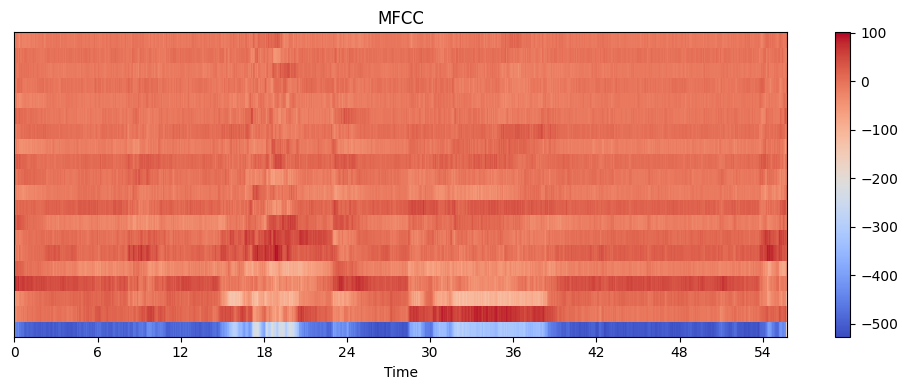

In [13]:
import librosa.display
import matplotlib.pyplot as plt

# Select one channel of the MFCC tensor
mfcc_channel_1 = mfcctensor.detach().numpy() # mfcctensor[0].detach().numpy()

# Plot the MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_channel_1, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [14]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f'Number of CPU cores: {num_cores}')

Number of CPU cores: 4


In [15]:
BATCH_SIZE = 32

train_size = int(0.8 * len(dataset1)) # + len(dataset2))) #int(0.8 * (len(dataset1) + len(dataset2) + len(dataset3)))
val_size = int(0.15 * len(dataset1)) #+ len(dataset2))) #int(0.1 * (len(dataset1) + len(dataset2) + len(dataset3)))
test_size = len(dataset1)  - train_size - val_size #  + len(dataset2) - train_size - val_size #len(dataset1) + len(dataset2) + len(dataset3) - train_size - val_size

dataset1.printPath = True
dataset2.printPath = True
dataset3.printPath = True

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size, test_size])  # + dataset2, [train_size, val_size, test_size]) # torch.utils.data.random_split(dataset1 + dataset2 + dataset3, [train_size, val_size, test_size])
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(len(train_dataset) + len(val_dataset) + len(test_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

1124 210 71
1405


In [16]:
# get the first element of the dataloader
dataiter = iter(train_dataloader)
mfcctensor, sample_rate, classe, file = next(dataiter)
print(mfcctensor.shape, sample_rate, classe)

torch.Size([32, 20, 2401]) tensor([48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000]) ['music', 'sot', 'animals', 'animals', 'animals', 'sot', 'music', 'sot', 'animals', 'music', 'music', 'animals', 'music', 'animals', 'sot', 'animals', 'music', 'animals', 'animals', 'music', 'animals', 'animals', 'music', 'music', 'music', 'sot', 'sot', 'sot', 'animals', 'music', 'music', 'music']


## Models

In [20]:
# dataloader arguments
batch_size = BATCH_SIZE

dtype = torch.float

In [21]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [22]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(num_steps):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)
    return torch.stack(spk_rec).cuda(), torch.stack(mem_rec).cuda()

In [23]:
def batch_accuracy(train_dataloader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_dataloader = iter(train_dataloader)
    for data, _, targets, _ in train_dataloader:
      data = data.cuda()
      data = data.unsqueeze(1)
      targets = name_tuple_to_float_tensor(targets).cuda().long()
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

## Simple Model

In [24]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(38208 , 3)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, _ = self.lif1(cur1, mem1)
        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, _ = self.lif2(cur2, mem2)
        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        
        return spk3, mem3

net = Net()

In [25]:
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(76416, 3),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
         )
net = nn.DataParallel(net, device_ids=device_ids).cuda()

In [29]:
loss_fn = SF.ce_rate_loss()

torch.Size([32])
tensor([1.0986], device='cuda:0', grad_fn=<DivBackward0>)
31.25 %


In [30]:
test_acc = batch_accuracy(val_dataloader, net, num_steps)
print(test_acc * 100, '%')

34.285714285714285 %


In [31]:
torch.cuda.empty_cache()

In [32]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, betas=(0.9, 0.999))
num_epochs = 40
loss_hist = []
test_acc_hist = []
counter = 0

for epoch in tqdm.trange(num_epochs):
    # Training loop
    for data, _, targets, _ in iter(train_dataloader):
        data = data.cuda()
        data = data.unsqueeze(1)
        targets = name_tuple_to_float_tensor(targets).cuda()
        targets = targets.long()


        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()
                
                test_acc = batch_accuracy(val_dataloader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

  0%|          | 0/40 [00:00<?, ?it/s]

Iteration 0, Test Acc: 34.29%



  2%|▎         | 1/40 [01:25<55:20, 85.14s/it]

Iteration 50, Test Acc: 34.29%



  5%|▌         | 2/40 [02:31<46:53, 74.05s/it]

Iteration 100, Test Acc: 51.90%



 10%|█         | 4/40 [04:44<40:55, 68.21s/it]

Iteration 150, Test Acc: 50.95%



 12%|█▎        | 5/40 [05:57<40:49, 70.00s/it]

Iteration 200, Test Acc: 48.10%



 15%|█▌        | 6/40 [07:03<38:53, 68.64s/it]

Iteration 250, Test Acc: 47.62%



 20%|██        | 8/40 [09:09<34:44, 65.14s/it]

Iteration 300, Test Acc: 51.43%



 22%|██▎       | 9/40 [10:17<34:06, 66.02s/it]

Iteration 350, Test Acc: 51.90%



 28%|██▊       | 11/40 [12:22<30:50, 63.80s/it]

Iteration 400, Test Acc: 51.90%



 30%|███       | 12/40 [13:30<30:21, 65.06s/it]

Iteration 450, Test Acc: 51.43%



 32%|███▎      | 13/40 [14:38<29:40, 65.96s/it]

Iteration 500, Test Acc: 53.33%



 38%|███▊      | 15/40 [16:46<26:54, 64.60s/it]

Iteration 550, Test Acc: 53.81%



 40%|████      | 16/40 [17:53<26:06, 65.27s/it]

Iteration 600, Test Acc: 53.33%



 45%|████▌     | 18/40 [20:00<23:30, 64.13s/it]

Iteration 650, Test Acc: 51.90%



 48%|████▊     | 19/40 [21:06<22:43, 64.95s/it]

Iteration 700, Test Acc: 51.43%



 50%|█████     | 20/40 [22:14<21:57, 65.86s/it]

Iteration 750, Test Acc: 54.29%



 55%|█████▌    | 22/40 [24:24<19:25, 64.76s/it]

Iteration 800, Test Acc: 53.81%



 57%|█████▊    | 23/40 [25:31<18:35, 65.63s/it]

Iteration 850, Test Acc: 54.76%



 62%|██████▎   | 25/40 [27:37<15:55, 63.71s/it]

Iteration 900, Test Acc: 56.67%



 65%|██████▌   | 26/40 [28:48<15:20, 65.72s/it]

Iteration 950, Test Acc: 54.29%



 68%|██████▊   | 27/40 [29:58<14:34, 67.26s/it]

Iteration 1000, Test Acc: 55.24%



 72%|███████▎  | 29/40 [32:04<11:49, 64.54s/it]

Iteration 1050, Test Acc: 54.29%



 75%|███████▌  | 30/40 [33:14<11:01, 66.13s/it]

Iteration 1100, Test Acc: 55.71%



 78%|███████▊  | 31/40 [34:22<10:00, 66.69s/it]

Iteration 1150, Test Acc: 55.71%



 82%|████████▎ | 33/40 [36:28<07:31, 64.43s/it]

Iteration 1200, Test Acc: 51.90%



 85%|████████▌ | 34/40 [37:40<06:39, 66.62s/it]

Iteration 1250, Test Acc: 51.43%



 90%|█████████ | 36/40 [39:48<04:18, 64.72s/it]

Iteration 1300, Test Acc: 52.38%



 92%|█████████▎| 37/40 [40:55<03:16, 65.49s/it]

Iteration 1350, Test Acc: 55.24%



 95%|█████████▌| 38/40 [42:02<02:11, 65.93s/it]

Iteration 1400, Test Acc: 54.29%



100%|██████████| 40/40 [44:08<00:00, 66.21s/it]


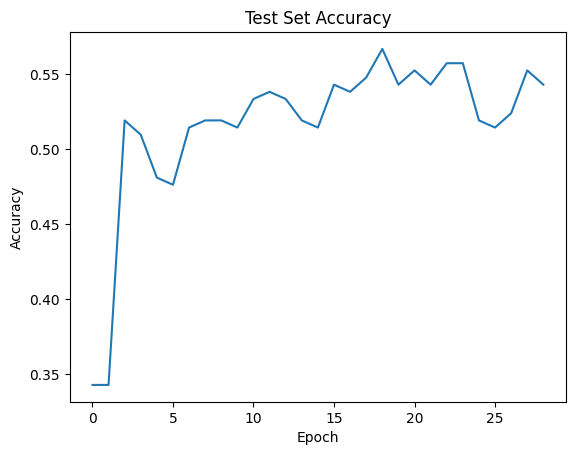

In [33]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [34]:
torch.cuda.empty_cache()

In [35]:
# get the first element of the dataloader
dataiter = iter(test_dataloader)
data, sample_rate, classe, file = next(dataiter)
print(data.shape, sample_rate, classe, file)

data = data.cuda()
data = data.unsqueeze(1)

torch.Size([32, 20, 2401]) tensor([48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,
        48000, 48000]) ['music', 'music', 'sot', 'animals', 'animals', 'animals', 'sot', 'animals', 'music', 'animals', 'sot', 'sot', 'animals', 'animals', 'animals', 'animals', 'animals', 'sot', 'music', 'music', 'music', 'music', 'music', 'music', 'music', 'sot', 'sot', 'sot', 'music', 'animals', 'music', 'animals'] ['/kaggle/input/audioset/TrainSet/Music/instruments_segmented/YIjP5kKfgBiI.wav', '/kaggle/input/audioset/TrainSet/Music/instruments_segmented/Y7IndxxjZe1c.wav', '/kaggle/input/audioset/TrainSet/SoT/sound_of_things_segmented/YE3YwyNv5zwk.wav', '/kaggle/input/audioset/TrainSet/Animals/animals_segmented/Y60dw27YRolU.wav', '/kaggle/input/audioset/TrainSet/Animals/animals_segmented/YKEVHD4Iz61k.wav', '/kaggle/input/audio

In [36]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

torch.Size([50, 32, 3])


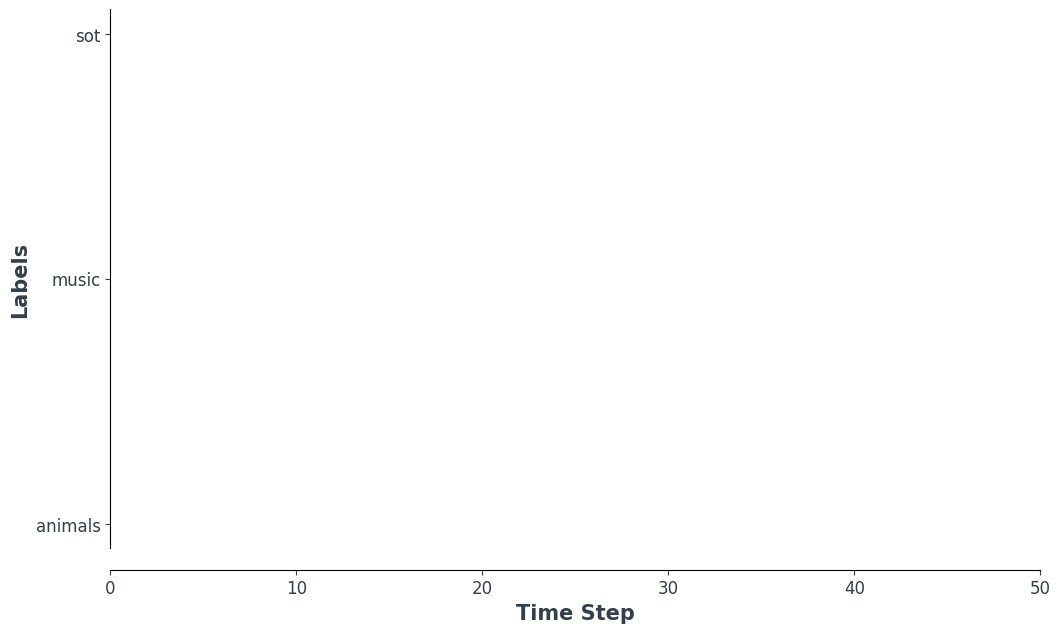

In [37]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['animals', 'music', 'sot']
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'
print(spk_rec.shape)
#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

In [38]:
print(f"The target label is: {targets[idx]}")

# Read audio file
waveform, sample_rate = torchaudio.load(file[idx])
print(waveform.shape, sample_rate)

# Read audio ipython
import IPython.display as ipd
ipd.Audio(waveform, rate=sample_rate)

The target label is: 1
torch.Size([2, 480000]) 48000


              precision    recall  f1-score   support

     Class 0       0.42      0.73      0.53        22
     Class 1       0.62      0.54      0.58        28
     Class 2       0.78      0.33      0.47        21

    accuracy                           0.54        71
   macro avg       0.61      0.53      0.53        71
weighted avg       0.61      0.54      0.53        71



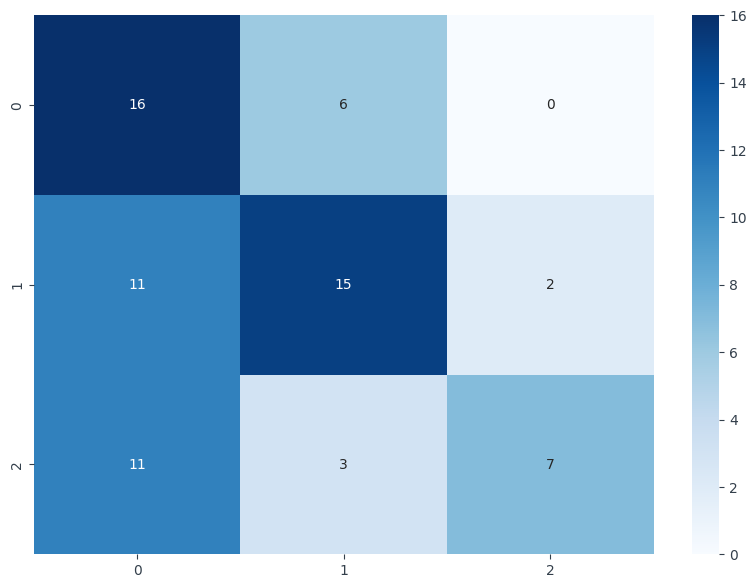

In [39]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the predictions for the test set
y_pred = []
y_true = []

with torch.no_grad():
    for data, _, labels, _ in test_dataloader:
        data = data.cuda()
        data = data.unsqueeze(1)
        labels = name_tuple_to_float_tensor(labels).cuda()
        labels = labels.long()
        outputs, _ = net(data)  # Assuming the model output is a tuple (spk3, mem3)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.tolist()
        y_true += labels.tolist()

# Compute and print a pretty confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Create a dataframe from the confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(num_classes)],
                     columns=[i for i in range(num_classes)])

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')

# Print the classification report
from sklearn.metrics import classification_report
class_names = [f'Class {i}' for i in range(num_classes)]
print(classification_report(y_true, y_pred, target_names=class_names))

In [40]:
# Save the model
torch.save(net.state_dict(), 'PATH')